## Exercises - Managing Database Objects

This exercise is primarily to assess your capabilities related to put all important DDL concepts in practice by coming up with solution for a typical data migration problem from one database (mysql) to another (SQL Server).
* Here are the high level steps for database migration from one type of database to another type of database.
  * Extract DDL Statements from source database (MySQL).
  * Extract the data in the form of delimited files and ship them to target database.
  * Refactor scripts as per target database (SQL Server).
  * Create tables in the target database.
  * Execute pre-migration steps (disable constraints, drop indexes etc).
  * Load the data using native utilities.
  * Execute post-migration steps (enable constraints, create or rebuild indexes, reset sequences etc).
  * Sanity checks with basic queries.
  * Make sure all the impacted applications are validated thoroughly.
* If you are using our environment the repository is already cloned under **/data/retail_db**.
* It have scripts to create tables with primary keys. Those scripts are generated from MySQL tables and refactored for Postgres.
  * Script to create tables: **create_db_tables_pg.sql**
  * Load data into tables: **load_db_tables_pg.sql**
* Here are the steps you need to perform to take care of this exercise.
  * Create tables
  * Load data
  * All the tables have surrogate primary keys. Here are the details.
    * orders.order_id
    * order_items.order_item_id
    * customers.customer_id
    * products.product_id
    * categories.category_id
    * departments.department_id
  * Get the maximum value from all surrogate primary key fields.
  * Create sequences for all surrogate primary key fields using maximum value. Make sure to use standard naming conventions for sequences.
  * Ensure sequences are mapped to the surrogate primary key fields.
  * Create foreign key constraints based up on this information.
    * orders.order_customer_id to customers.customer_id
    * order_items.order_item_order_id to orders.order_id
    * order_items.order_item_product_id to products.product_id
    * products.product_category_id to categories.category_id
    * categories.category_department_id to departments.department_id
  * Insert few records in `departments` to ensure that sequence generated numbers are used for `department_id`.
* Here are the commands to launch `psql` and run scripts to create tables as well as load data into tables.

```sql
psql -U retail_user \
  -h localhost \
  -p 5432 \
  -d retail_db \
  -W

\i /data/retail_db/create_db_tables_pg.sql

\i /data/retail_db/load_db_tables_pg.sql
```
* We use this approach of creating tables, loading data and then adding constraints as well as resetting sequences for large volume data migrations from one database to another database.
* Here are the commands or queries you need to come up with to solve this problem.

### Exercise 1

Queries to get maximum values from surrogate primary keys. Alter the script to create the primary key column with the correct value to insert new data.

<br />

Code:
```sql

SELECT MAX(order_id) AS max_id
FROM orders;

SELECT MAX(category_id) AS max_id
FROM categories;

SELECT MAX(customer_id) AS max_id
FROM customers;

SELECT MAX(department_id) AS max_id
FROM departments;

SELECT MAX(order_item_id) AS max_id
FROM order_items;

SELECT MAX(product_id) AS max_id
FROM products;
```
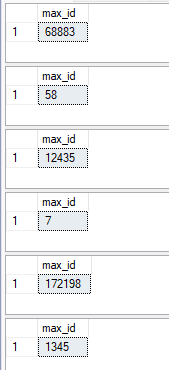

### Exercise 2

Add Foreign Key constraints to the tables.
* Validate if the tables have data violataing foreign key constraints (Hint: You can use left outer join to find rows in child table but not in parent table)
* Alter tables to add foreign keys as specified.
* Here are the relationships for your reference.
  * orders.order_customer_id to customers.customer_id
  * order_items.order_item_order_id to orders.order_id
  * order_items.order_item_product_id to products.product_id
  * products.product_category_id to categories.category_id
  * categories.category_department_id to departments.department_id
  * There might be data in child table, which might not be in parent table. You should figure out as part of the validations.
  * If there are foreign key violations, make sure to update the data in the child table's foreign key column to null values.
* Solution should contain the following:
  * Commands to add foreign keys to the tables.

<br />

Code:
```sql

-- orders.order_customer_id to customers.customer_id
ALTER TABLE orders
ADD CONSTRAINT FK_orders_customers
FOREIGN KEY (order_customer_id)
REFERENCES customers (customer_id);

-- order_items.order_item_order_id to orders.order_id
ALTER TABLE order_items
ADD CONSTRAINT FK_orders_items_orders
FOREIGN KEY (order_item_order_id)
REFERENCES orders (order_id);

-- order_items.order_item_product_id to products.product_id
ALTER TABLE order_items
ADD CONSTRAINT FK_orders_items_products
FOREIGN KEY (order_item_product_id)
REFERENCES products (product_id);

-- products.product_category_id to categories.category_id
-- There are products with categories that dont exist in the categories table so we need to delete those
-- Finding all products that violate foreign key constraints
SELECT * FROM products p
LEFT JOIN categories c on p.product_category_id = c.category_id
WHERE c.category_id is NULL;
-- Deleting them
DELETE FROM products
WHERE product_category_id NOT IN (SELECT category_id from categories);
-- Adding the constraints now that the bad products are gone
ALTER TABLE products
ADD CONSTRAINT FK_products_categories
FOREIGN KEY (product_category_id)
REFERENCES categories (category_id);

-- categories.category_department_id to departments.department_id
-- There are categories with departments that don't exist in the departments table 
-- This time we will try adding the missing departments
SELECT * FROM categories c
LEFT JOIN departments d on c.category_department_id = d.department_id
WHERE d.department_id is NULL;
-- WE see that department 8 exist in category and not in the departments table so lets add it
INSERT INTO departments
VALUES(8,'Sports');
-- Adding constraints now that we have a department for that category
ALTER TABLE categories
ADD CONSTRAINT FK_categories_departments
FOREIGN KEY (category_department_id)
REFERENCES departments (department_id);
```

### Exercise 3

Queries to validate whether constraints are created or not. You can come up with queries against `information_schema` tables such as `columns`, `sequences` etc.

<br />

Code:
```sql

SELECT *
FROM INFORMATION_SCHEMA.TABLE_CONSTRAINTS
WHERE CONSTRAINT_TYPE = 'FOREIGN KEY'
AND TABLE_NAME in ('orders','order_items','products','categories');
```

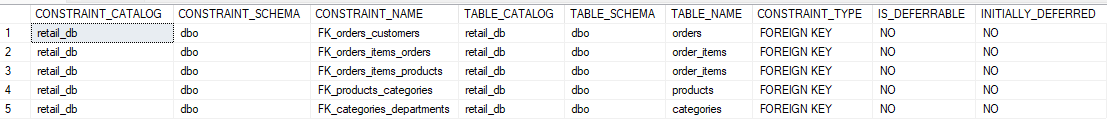

We see the 5 foreign key constraints that we made.